**Explanation**

## User-Agnostic Multipartite Ranking

This notebook implements a userAgnostic ranking system using user clusters and filtering to improve item ranking fairness and robustness.

### **How it Works**

1.  **Cluster Rankings:**
    * Initial item rankings are computed within each user cluster, requiring minimum rating counts.
    * Clusters smaller than a given threshold are assigned to the Complementary cluster.
2.  **Intra-Cluster Reputation:**
    * Within each cluster ratings that deviate from the item average are filtered out.
3.  **Convergence & Visualization:**
    * The system iterates until rankings converge (no more ratings are filtered out).
4.  **Weighted Average:**
    * A weighted average ranking for each item is computed, using the cluster sizes as weight.
5.  **Top 3 Clusters**
    * A visualization of the distribution of rankings on the top 3 clusters is provided.

### **This notebook will:**

* Cluster users,
* Compute cluster-specific rankings with thresholds,
* Generate weighted average rankings using reputation,
* Visualize distribution of rankings.

**1.    Imports**

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import zlib
import pickle
import os
import matplotlib.pyplot as plt
from itertools import combinations
import sys
import math
from collections import Counter
from scipy.stats import zscore
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import kendalltau
import csv

compressed_sizes = {}


**2.    Load dataset**

In [2]:
# Define dataset path
file_path = "/home/martim/Desktop/tese/datasets/book_crossing/book_ratings_normalized.dat"

# Load dataset
df = pd.read_csv(file_path, sep='\t', header=0)  # Properly use the first row as headers

# Display first few rows
df.head()

,user_id,item_id,rating,normalized_rating,Unnamed: 4
0,1,6264,7.0,0.7,NaN
1,1,4350,7.0,0.7,NaN
2,1,6252,5.0,0.5,NaN
3,1,202,9.0,0.9,NaN
4,1,6266,6.0,0.6,NaN


**3.    Dictionary with pre-computed values**

In [3]:
def compute_compressed_sizes(user_ratings):
    
    for user, ratings in user_ratings.items():
        u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings.items()))
        compressed_sizes[u_string] = len(zlib.compress(u_string.encode()))
    
    return compressed_sizes


**4.    Similarities**

In [5]:
def linear_similarity(ratings_u, ratings_v):
    common_items = set(ratings_u.keys()).intersection(set(ratings_v.keys()))
    if not common_items:
        return 0  # If no common items, similarity is 0

    diff_sum = sum(abs(ratings_u[i] - ratings_v[i]) for i in common_items)
    ls_value = 1 - (diff_sum / len(common_items))
    return max(0, ls_value)  # Ensure similarity is non-negative

# Compression Similarity with precomputed sizes
def compression_similarity(ratings_u, ratings_v):
    u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_v.items()))
    c_uv = len(zlib.compress((u_string + v_string).encode()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 - (c_uv - min(c_u, c_v)) / max(c_u, c_v)

# Kolmogorov Similarity with precomputed sizes
def kolmogorov_similarity(ratings_u, ratings_v):
    #ordena a priori os ratings dado por cada user
    u_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_u.items()))
    v_string = "".join(f"{k}:{v} " for k, v in sorted(ratings_v.items()))
    c_u = compressed_sizes[u_string]
    c_v = compressed_sizes[v_string]
    return 1 / (1 + abs(c_u - c_v))

def jaccard_similarity(ratings_u, ratings_v):
    """
    Computes the Jaccard Similarity between two users' rating sets.
    It considers only the presence of ratings, not their values.
    """
    items_u = set(ratings_u.keys())
    items_v = set(ratings_v.keys())
    
    intersection = items_u.intersection(items_v)
    union = items_u.union(items_v)
    
    if not union:
        return 0  # Avoid division by zero
    
    return len(intersection) / len(union)

def cosine_similarity(ratings_u, ratings_v):
    """
    Computes the Cosine Similarity between two users' rating vectors.
    """
    common_items = set(ratings_u.keys()).intersection(set(ratings_v.keys()))
    
    if not common_items:
        return 0  # If no common items, similarity is 0

    # Compute dot product and magnitudes
    dot_product = sum(ratings_u[i] * ratings_v[i] for i in common_items)
    magnitude_u = math.sqrt(sum(ratings_u[i] ** 2 for i in ratings_u))
    magnitude_v = math.sqrt(sum(ratings_v[i] ** 2 for i in ratings_v))
    
    if magnitude_u == 0 or magnitude_v == 0:
        return 0  # Avoid division by zero
    
    return dot_product / (magnitude_u * magnitude_v)



**5.    Simlarity Matrix and graph**

In [6]:
# Compute user similarity matrix and construct graph (with precomputed sizes)
def compute_similarity_matrix(user_ratings, similarity_measure, compressed_sizes, similarity_threshold):
    similarity_graph = nx.Graph()

    # Step 1: Add all users as nodes (ensures isolated users are included)
    similarity_graph.add_nodes_from(user_ratings.keys())

    # Step 2: Compute pairwise similarities and add edges if similarity > 0.99
    for (u, v) in combinations(user_ratings.keys(), 2):
        sim = similarity_measure(user_ratings[u], user_ratings[v])
        if sim > similarity_threshold:
            similarity_graph.add_edge(u, v, weight=sim)

    return similarity_graph

# Detect user clusters from similarity graph
def detect_groups(similarity_graph,min_cluster_size):
    """ Detect user clusters from similarity graph and assign small clusters to a complementary cluster. """
    clusters = list(nx.connected_components(similarity_graph))
    complementary_cluster = set()
    filtered_clusters = []

    for cluster in clusters:
        if len(cluster) < min_cluster_size:
            complementary_cluster.update(cluster)  # Add small clusters to the complementary cluster
        else:
            filtered_clusters.append(cluster)  # Keep large clusters as they are

    if complementary_cluster:
        filtered_clusters.append(complementary_cluster)  # Add complementary cluster if it has users

    filtered_cluster_sizes = [len(group) for group in filtered_clusters]
    print("Number of clusters: ", len(filtered_clusters))
    print("complementary_cluster: ", len(complementary_cluster))
    mean_size = np.mean(filtered_cluster_sizes)
    std_size = np.std(filtered_cluster_sizes)
    z_score = (len(complementary_cluster) - mean_size) / std_size if std_size > 0 else float('inf')
    print("z_score: ", z_score)

    return filtered_clusters

**6.    Reputation-based intra-clustering**

In [150]:
def compute_cluster_ratings(df, user_groups):
    """ Compute initial ratings per cluster based only on the items rated by at least 5 users in the cluster. """
    cluster_item_ratings = {}
    item_raters = {}  # Dictionary to store item-wise users

    # Iterate through each user cluster
    for cluster_idx, user_set in enumerate(user_groups, start=1): 
        cluster_df = df[df["user_id"].isin(user_set)]  # Filter dataset to only include users in the cluster
        item_rating_counts = cluster_df["item_id"].value_counts()  # Count ratings per item
        
        # Filter items that have at least x ratings
        valid_items = item_rating_counts[item_rating_counts >= 1].index  

        # Compute the mean only for valid items
        filtered_avg_ratings = cluster_df[cluster_df["item_id"].isin(valid_items)].groupby("item_id")["normalized_rating"].mean().to_dict()

        # Store which users rated each item
        for item in valid_items:
            item_raters[item] = set(cluster_df[cluster_df["item_id"] == item]["user_id"])

        cluster_item_ratings[cluster_idx] = filtered_avg_ratings

    return cluster_item_ratings, item_raters
def refine_cluster_ratings(df, user_groups, cluster_item_ratings):
    """Refine cluster ratings by filtering out extreme user ratings based on squared deviation threshold."""
    refined_ratings = {}
    total_ratings_count = 0
    total_filtered_count = 0
    filtered_ratings = {}  # Dictionary to store filtered ratings

    for cluster_idx, user_set in enumerate(user_groups, start=1):
        if cluster_idx not in cluster_item_ratings:
            continue  # Skip clusters without precomputed ratings

        cluster_df = df[df["user_id"].isin(user_set)]
        final_ratings = cluster_item_ratings[cluster_idx].copy()

        for item in final_ratings.keys():
            item_ratings = cluster_df[cluster_df["item_id"] == item][["user_id", "normalized_rating"]].copy()

            total_ratings = len(item_ratings)
            total_ratings_count += total_ratings
            previous_avg = None
            current_avg = item_ratings["normalized_rating"].mean()
            filtered_count = 0

            while previous_avg is None or abs(current_avg - previous_avg) > 1e-6:
                previous_avg = current_avg
                std_dev = item_ratings["normalized_rating"].std(ddof=0)  # Population standard deviation
                if std_dev is None or std_dev == 0:
                    break  # Stop if no deviation exists

                # Apply new filter condition: (rating - mean)^2 ≤ std
                item_ratings["squared_deviation"] = (item_ratings["normalized_rating"] - current_avg) ** 2
                valid_ratings = item_ratings[item_ratings["squared_deviation"] <= std_dev]
                filtered_out = item_ratings[item_ratings["squared_deviation"] > std_dev]

                if not filtered_out.empty:
                    if item not in filtered_ratings:
                        filtered_ratings[item] = []
                    filtered_ratings[item].extend(list(zip(filtered_out["user_id"], filtered_out["normalized_rating"])))

                filtered_count = total_ratings - len(valid_ratings)
                total_filtered_count += filtered_count

                if valid_ratings.empty:
                    break  # Stop if no valid ratings remain

                current_avg = valid_ratings["normalized_rating"].mean()
                item_ratings = valid_ratings.copy()  # Continue refining only on retained values

            final_ratings[item] = current_avg

        refined_ratings[cluster_idx] = final_ratings

    print(f"Total Ratings: {total_ratings_count} | Total Filtered: {total_filtered_count}")

    return refined_ratings, filtered_ratings



def compute_weighted_average_cluster_ratings(cluster_item_ratings, user_groups):
    """Compute weighted average ratings for each item across clusters using cluster size as weight."""
    item_weighted_sums = {}
    item_total_weights = {}
    
    # Iterate over clusters and their item ratings
    for cluster_idx, item_ratings in cluster_item_ratings.items():
        cluster_size = len(user_groups[cluster_idx - 1])  # Cluster index is 1-based, user_groups is 0-based
        
        for item, rating in item_ratings.items():
            if item not in item_weighted_sums:
                item_weighted_sums[item] = 0
                item_total_weights[item] = 0
            
            # Add weighted contribution
            item_weighted_sums[item] += rating * cluster_size
            item_total_weights[item] += cluster_size
    
    # Compute weighted averages and round to the nearest decimal place
    weighted_averages = {item: round(item_weighted_sums[item] / item_total_weights[item], 1) for item in item_weighted_sums}
    
    return weighted_averages


def round_ratings_to_one_decimal(new_ratings):
    """Round all item ratings to the nearest one decimal place."""
    return {cluster: {item: round(rating, 1) for item, rating in items.items()} for cluster, items in new_ratings.items()}




**7.    Plot Generation**

In [10]:
def plot_top_3_clusters(cluster_ratings):
    """Plot a bar chart showing the rating distribution for the three largest clusters with bins."""
    # Sort clusters by size (number of items rated) in descending order
    top_clusters = sorted(cluster_ratings.keys(), key=lambda c: len(cluster_ratings[c]), reverse=True)[:3]

    # Define bins from 0.1 to 1.0 (inclusive)
    bins = np.arange(0.05, 1.05, 0.1)  # Bin centers
    bin_labels = [round(b, 1) for b in np.arange(0.1, 1.1, 0.1)]  # Labels for x-axis

    plt.figure(figsize=(12, 5))

    # Adjust vertical position offset for each cluster
    vertical_offset = 0.0

    for cluster in top_clusters:
        # Flatten ratings in the cluster
        ratings = list(cluster_ratings[cluster].values())

        # Digitize ratings into bins
        bin_indices = np.digitize(ratings, bins, right=True)
        bin_counts = Counter(bin_indices)

        # Create an aligned count array
        counts = [bin_counts[i + 1] if i + 1 in bin_counts else 0 for i in range(len(bin_labels))]

        # Plot the bar chart for the cluster, adjusting the position of the bars
        plt.bar(bin_labels, counts, width=0.07, alpha=0.6, label=f'Cluster {cluster}', bottom=vertical_offset)

        # Add value labels with a vertical offset for readability
        for i, count in enumerate(counts):
            if count > 0:
                plt.text(bin_labels[i], count + vertical_offset + 0.5, str(count), ha='center', fontsize=10)

        # Update the vertical offset for the next cluster
        vertical_offset += max(counts) + 2  # Adjust the offset based on the max count in the current cluster

    plt.xlabel("Item Rating (Binned from 0.1 to 1.0)")
    plt.ylabel("Number of Items")
    plt.title("Cosine 0.6 | reputation threshold 0.95")
    plt.xticks(bin_labels)
    plt.legend()
    plt.show()



def plot_weighted_average_distribution(weighted_average_dict):
    """Plot a bar chart showing the distribution of weighted average ratings with bins from 0.1 to 1.0."""
    # Flatten weighted averages
    ratings = list(weighted_average_dict.values())

    # Define bins from 0.1 to 1.0
    bins = np.arange(0.05, 1.05, 0.1)  # Bin centers
    bin_labels = [round(b, 1) for b in np.arange(0.1, 1.1, 0.1)]  # Labels for x-axis

    # Digitize ratings into bins
    bin_indices = np.digitize(ratings, bins, right=True)
    bin_counts = Counter(bin_indices)

    # Create an aligned count array
    counts = [bin_counts[i + 1] if i + 1 in bin_counts else 0 for i in range(len(bin_labels))]

    # Plot the bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(bin_labels, counts, width=0.07, color='blue', alpha=0.7)

    # Add value labels
    for i, count in enumerate(counts):
        if count > 0:
            plt.text(bin_labels[i], count + 0.5, str(count), ha='center', fontsize=10)

    plt.xlabel("Weighted Average Rating (Binned from 0.1 to 1.0)")
    plt.ylabel("Number of Items")
    plt.title("Distribution of Weighted Average Ratings (Binned)")
    plt.xticks(bin_labels)
    plt.show()

**8.    Main function**

In [11]:
# Prepare user ratings
user_ratings = {user: dict(zip(group["item_id"], group["normalized_rating"])) for user, group in df.groupby("user_id")}

print("\nuser_ratings: ", user_ratings)
# Compute or load compressed sizes
compressed_sizes = compute_compressed_sizes(user_ratings)
print("comprimido")


user_ratings:  {1: {6264: 0.7, 4350: 0.7, 6252: 0.5, 202: 0.9, 6266: 0.6, 4810: 0.5, 6251: 0.9, 160: 0.9, 161: 0.8, 631: 1.0, 6244: 0.7, 6260: 0.8, 6229: 1.0, 2072: 0.9, 6254: 0.8, 1514: 0.9, 2566: 0.9, 1714: 0.9, 1893: 0.9, 2955: 0.9, 2565: 0.9, 2864: 0.8, 5988: 0.6, 164: 0.7, 1119: 0.9, 167: 0.8, 6265: 0.8, 1440: 0.9, 1427: 0.9, 5404: 0.8, 259: 0.7, 4156: 0.8}, 2: {419: 0.9, 415: 1.0, 2834: 0.9, 228: 1.0, 107: 1.0, 440: 0.9, 44: 1.0, 455: 1.0, 6302: 1.0, 1208: 0.9, 412: 1.0, 438: 1.0, 433: 1.0, 432: 0.9, 6301: 0.9, 407: 1.0, 416: 1.0, 437: 0.8, 414: 0.9, 424: 1.0, 408: 0.9, 5096: 0.9, 428: 1.0, 429: 1.0, 418: 0.8, 427: 0.8, 410: 0.7, 425: 0.9, 417: 1.0, 5691: 1.0, 1067: 0.9, 1564: 0.7, 1560: 1.0, 411: 0.9, 439: 0.9, 423: 1.0, 1159: 1.0, 616: 0.8, 430: 0.9}, 5: {2957: 1.0, 6318: 1.0, 6327: 0.5, 716: 0.5, 645: 0.7, 648: 1.0, 407: 1.0, 651: 1.0, 7200: 1.0, 376: 1.0, 11701: 0.9, 976: 1.0, 3762: 0.9, 6326: 0.9, 6320: 0.9, 519: 0.6, 1419: 0.6, 6317: 0.8, 1291: 0.9, 6046: 1.0, 6310: 1.0, 6

**9.    User Demographics**

In [178]:
import csv

# Define age ranges
age_ranges = {
    "< 18": lambda age: age < 18,
    "18-24": lambda age: 18 <= age <= 24,
    "25-34": lambda age: 25 <= age <= 34,
    "35-44": lambda age: 35 <= age <= 44,
    "45-49": lambda age: 45 <= age <= 49,
    "50-55": lambda age: 50 <= age <= 55,
    "> 55": lambda age: age > 55,
}

# Define country to continent mapping
country_to_continent = {
    "usa": "Americas", "united states": "Americas", "united state": "Americas",
    "canada": "Americas", "brazil": "Americas", "dominican republic": "Americas",
    "argentina": "Americas", "mexico": "Americas", "chile": "Americas",
    "venezuela": "Americas", "colombia": "Americas", "peru": "Americas",
    "puerto rico": "Americas", "uruguay": "Americas",
    
    "egypt": "Africa", "south africa": "Africa", "morocco": "Africa",
    "nigeria": "Africa", "tunisia": "Africa",
    
    "china": "Asia/Oceania", "japan": "Asia/Oceania", "australia": "Asia/Oceania",
    "new zealand": "Asia/Oceania", "iran": "Asia/Oceania", "kuwait": "Asia/Oceania",
    "malaysia": "Asia/Oceania", "philippines": "Asia/Oceania", "phillipines": "Asia/Oceania",
    "hong kong": "Asia/Oceania", "singapore": "Asia/Oceania", "taiwan": "Asia/Oceania",
    "india": "Asia/Oceania", "indonesia": "Asia/Oceania", "south korea": "Asia/Oceania",
    "pakistan": "Asia/Oceania", "thailand": "Asia/Oceania", "vietnam": "Asia/Oceania",
    
    "france": "Europe", "germany": "Europe", "united kingdom": "Europe",
    "italy": "Europe", "netherlands": "Europe", "sweden": "Europe",
    "switzerland": "Europe", "spain": "Europe", "norway": "Europe",
    "finland": "Europe", "denmark": "Europe", "portugal": "Europe",
    "romania": "Europe", "russia": "Europe", "poland": "Europe",
    "belgium": "Europe", "austria": "Europe", "iceland": "Europe",
    "czech republic": "Europe", "bulgaria": "Europe", "cyprus": "Europe",
    "greece": "Europe", "ireland": "Europe", "slovakia": "Europe",
    "croatia": "Europe", "hungary": "Europe", "serbia": "Europe",
    
    "far away...": "Unknown", "universe": "Unknown", "burma": "Unknown", "qatar": "Unknown",
    "unknown": "Unknown"
}

def extract_country(location):
    """Extracts the country from the location string by taking the last part."""
    parts = location.lower().split(",")  # Split location by commas
    country = parts[-1].strip() if parts else "unknown"
    return country_to_continent.get(country, "Unknown")  # Return continent or "Unknown"

def process_users_info(file_path):
    """Processes users_info.dat to group users by age range and continent."""
    age_groups = {key: set() for key in age_ranges.keys()}
    continent_groups = {}

    with open(file_path, "r", encoding="utf-8") as file:
        reader = csv.reader(file, delimiter="\t")  # Tab-separated values
        for row in reader:
            if len(row) < 3:
                continue  # Skip malformed rows

            try:
                user_id = int(row[0])  # Convert user_id to integer
                location = row[1]
                age = int(row[2])

                # Process age
                for group, condition in age_ranges.items():
                    if condition(age):
                        age_groups[group].add(user_id)
                        break

                # Process continent
                continent = extract_country(location)
                if continent not in continent_groups:
                    continent_groups[continent] = set()
                continent_groups[continent].add(user_id)

            except ValueError:
                pass  # Skip invalid age or user ID values

    return age_groups, continent_groups

# Example usage
file_path = "/home/martim/Desktop/tese/datasets/book_crossing/users_info.dat"  # Update with actual path
age_groups, continent_groups = process_users_info(file_path)

# Print results
print("Age Groups:", {k: len(v) for k, v in age_groups.items()})
print("age_groups: ", age_groups)
print("Continent Groups:", {k: len(v) for k, v in continent_groups.items()})
print("continent_groups: ", continent_groups)


Age Groups: {'< 18': 84, '18-24': 358, '25-34': 1104, '35-44': 754, '45-49': 223, '50-55': 200, '> 55': 222}
age_groups:  {'< 18': {3, 2563, 2565, 1544, 1050, 545, 2083, 2094, 2096, 565, 58, 1083, 1595, 2636, 1109, 2133, 2652, 607, 98, 2147, 621, 2673, 2162, 2168, 2170, 122, 1155, 1668, 646, 654, 660, 1176, 1692, 2206, 2726, 2219, 1196, 2754, 716, 2253, 2766, 1231, 1233, 2782, 2791, 1772, 237, 1271, 2807, 765, 254, 272, 1302, 2854, 1832, 810, 302, 2355, 311, 2377, 2379, 847, 2383, 2384, 2387, 2914, 879, 376, 1915, 1944, 944, 1459, 448, 1986, 461, 973, 2522, 989, 1508, 2539, 1004, 1007, 1022, 2559}, '18-24': {2, 5, 2054, 7, 8, 12, 17, 2066, 23, 28, 29, 2077, 2082, 35, 40, 2091, 2100, 2102, 2103, 62, 2111, 65, 66, 67, 2115, 2118, 2122, 80, 83, 2131, 87, 2136, 2140, 93, 100, 2150, 105, 2154, 2157, 2158, 112, 113, 114, 115, 117, 2171, 2172, 2174, 128, 133, 134, 2181, 138, 140, 141, 2204, 158, 160, 2210, 2220, 175, 2224, 2230, 186, 2240, 192, 194, 2245, 200, 2255, 209, 2258, 211, 2264, 228,

**10. Clustering**

In [16]:
# Choose similarity measure: linear_similarity, compression_similarity, kolmogorov_similarity
similarity_graph = compute_similarity_matrix(user_ratings, kolmogorov_similarity, compressed_sizes, 0.9)

# Get threshold for complementary cluster
num_users = df["user_id"].nunique()
complementary_cluster_threshold = num_users * 0.005

# Detect user clusters from similarity graph
user_groups = detect_groups(similarity_graph, complementary_cluster_threshold)

# Print the number of detected clusters
print(f"User groups: {(user_groups)}")

print("number of user_groups: ", len(user_groups))

#count total number of elements in usergroups
total = 0
for group in user_groups:
    total += len(group)
print("total number of elements in usergroups: ", total)

#biggest user group, average size of user groups
biggest = 0
for group in user_groups:
    if len(group) > biggest:
        biggest = len(group)
print("biggest user group: ", biggest)

average = total / len(user_groups)
print("average size of user groups: ", average)





Number of clusters:  61
complementary_cluster:  532
z_score:  7.726876857103692
User groups: [{2016, 1, 802, 1730, 2624, 2379, 1262, 1712, 337, 531, 2611, 2809, 313}, {1153, 2, 1829, 1350, 170, 715, 1547, 2252, 2256, 945, 1169, 1107, 2324, 245, 2038, 1431, 1372}, {1220, 5, 2183, 1064, 2343, 1866, 2667, 1997, 944, 817, 181, 863, 991, 733, 735}, {769, 258, 386, 9, 2825, 1931, 2444, 2579, 1940, 1817, 1561, 1448, 2345, 2729, 2857, 60, 600, 1768, 367, 1907, 629}, {513, 1929, 1002, 1354, 1546, 2766, 1808, 2808, 754, 20, 532, 1911, 1944, 762, 2136, 444, 1374}, {512, 651, 140, 22, 2464, 1445, 678, 2726, 1581, 439, 1080, 186, 188, 831, 575, 2375, 1355, 2391, 2912, 105, 2411, 1518, 881, 1919}, {1634, 1544, 2794, 47, 1425, 1493, 24, 90, 2875, 1309, 1469}, {2465, 1027, 804, 1990, 268, 109, 428, 1073, 211, 213, 2359, 1336, 25, 1148}, {1799, 908, 1684, 26, 155, 796, 2206, 546, 2878, 702, 2881, 708, 203, 351, 610, 747, 1010, 247, 1273, 2302}, {2050, 654, 1167, 1687, 1176, 1569, 34, 1697, 1714, 563, 5

**11.   K-means Clustering**


In [10]:
df = pd.DataFrame(user_ratings).T.fillna(0)  # Fill missing values with 0

scaler = StandardScaler()
normalized_data = scaler.fit_transform(df)

k = 5  # Number of clusters (choose based on Elbow Method)
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(df)

# Assign cluster labels to users
df["cluster"] = clusters

cluster_map = {}
for user, cluster in zip(df.index, clusters):
    cluster_map.setdefault(cluster, []).append(user)

# Print the resulting cluster dictionary
print(cluster_map)


{3: [1, 2, 5, 7, 9, 11, 14, 16, 18, 20, 22, 24, 25, 26, 29, 31, 34, 44, 47, 48, 49, 52, 53, 57, 59, 60, 63, 69, 71, 73, 76, 78, 83, 90, 92, 93, 94, 99, 101, 103, 105, 109, 110, 113, 115, 118, 120, 121, 123, 124, 125, 131, 136, 137, 138, 140, 145, 152, 153, 154, 155, 157, 158, 162, 164, 167, 169, 170, 173, 177, 180, 181, 182, 186, 187, 188, 190, 191, 192, 193, 194, 195, 200, 201, 202, 203, 204, 205, 208, 209, 211, 213, 217, 218, 222, 225, 232, 234, 235, 243, 245, 246, 247, 248, 252, 253, 255, 257, 258, 259, 266, 267, 268, 271, 273, 275, 276, 279, 282, 290, 295, 297, 299, 301, 310, 311, 312, 313, 314, 318, 321, 322, 323, 325, 334, 335, 337, 339, 340, 341, 342, 343, 345, 346, 349, 350, 351, 353, 354, 355, 356, 358, 364, 366, 367, 369, 372, 376, 377, 383, 384, 385, 386, 388, 391, 392, 394, 396, 400, 401, 403, 405, 411, 415, 416, 418, 421, 425, 427, 428, 429, 431, 432, 437, 438, 439, 441, 444, 447, 448, 449, 450, 457, 460, 464, 465, 468, 471, 473, 474, 476, 477, 487, 489, 490, 493, 495, 496

**12.   Ranking computation**


cluster_item_ratings:  {1: {2: 0.6, 8: 0.6, 10: 0.8, 49: 0.6, 54: 0.9, 144: 0.6, 160: 0.9, 161: 0.8, 164: 0.7, 167: 0.8, 202: 0.9, 223: 0.7, 228: 0.9, 259: 0.7, 261: 1.0, 297: 0.95, 407: 0.9, 410: 0.7, 466: 0.9, 469: 0.6, 561: 1.0, 589: 0.9, 599: 0.8, 607: 0.5, 613: 0.5, 631: 1.0, 648: 0.8, 674: 0.9, 681: 0.8, 747: 0.5, 770: 0.6, 790: 0.8, 811: 0.7, 855: 0.9, 856: 0.8, 868: 0.7, 877: 0.9, 889: 0.9, 908: 0.7, 912: 0.7, 927: 0.8, 949: 0.6, 962: 1.0, 993: 0.6, 997: 0.4, 1014: 0.8, 1018: 0.4, 1095: 0.8, 1110: 0.7, 1111: 0.8, 1119: 0.9, 1136: 0.9, 1191: 0.6, 1208: 0.55, 1219: 0.8, 1289: 0.8, 1292: 0.7, 1293: 0.8, 1294: 1.0, 1323: 0.7, 1425: 0.8, 1427: 0.9, 1439: 1.0, 1440: 0.9, 1463: 1.0, 1514: 0.6, 1519: 0.8, 1527: 0.8, 1535: 1.0, 1543: 0.8, 1565: 0.8, 1692: 0.7, 1701: 0.9, 1706: 0.7, 1714: 0.9, 1730: 1.0, 1765: 0.5, 1784: 0.8, 1795: 0.7, 1796: 1.0, 1835: 1.0, 1845: 0.3, 1866: 0.8, 1868: 0.9, 1893: 0.9, 1901: 0.6, 1919: 0.9, 1920: 0.9, 1952: 0.5, 1974: 0.7, 2066: 1.0, 2067: 1.0, 2072: 0.9,

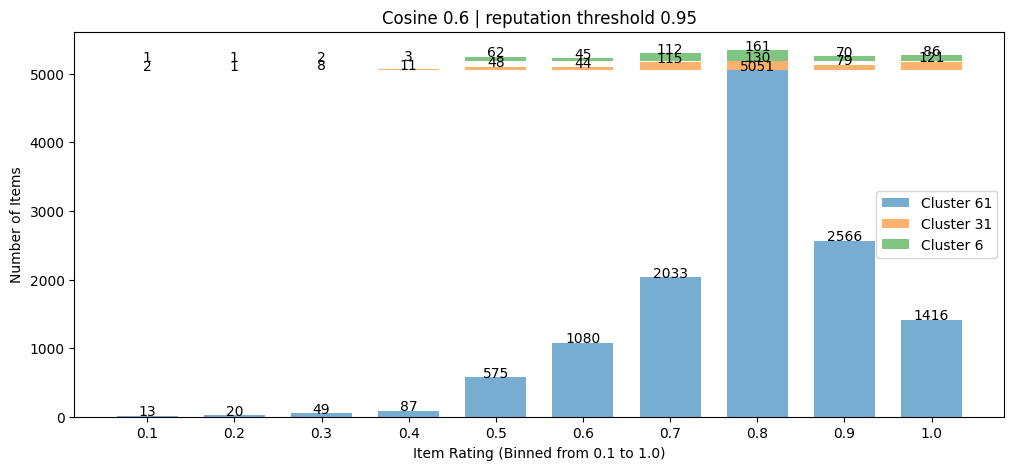

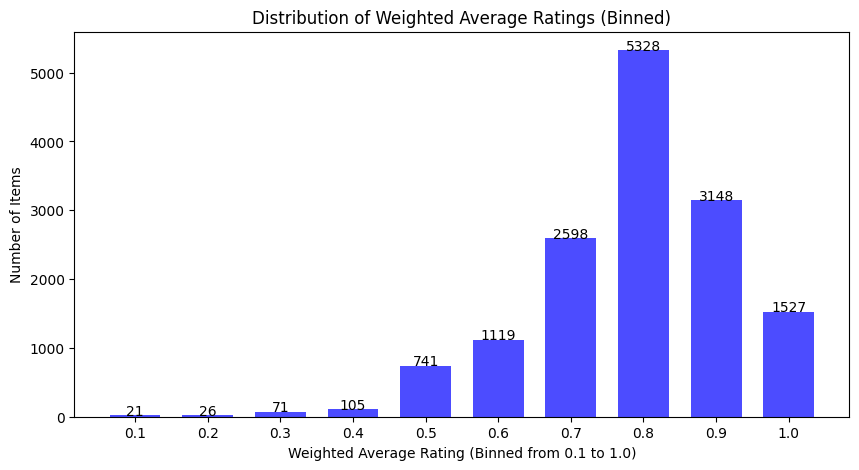

In [180]:
# Assuming user_groups is already defined
cluster_item_ratings, item_raters = compute_cluster_ratings(df, user_groups)  # Step 1: Compute initial ratings

print("cluster_item_ratings: ", cluster_item_ratings)

print("item_raters: ", item_raters)

refined_cluster_ratings, filtered_ratings_byItem = refine_cluster_ratings(df, user_groups, cluster_item_ratings)  # Step 2: Refine ratings

print("refined_cluster_ratings: ", refined_cluster_ratings)
print("filtered_ratings_byItem: ", filtered_ratings_byItem)

weighted_average_dict = compute_weighted_average_cluster_ratings(refined_cluster_ratings, user_groups)

# round all clusters values 
rounded_ratings = round_ratings_to_one_decimal(refined_cluster_ratings)

print("rounded_ratings: ", rounded_ratings)
print("len(rounded_ratings): ", len(rounded_ratings))

plot_top_3_clusters(rounded_ratings)  # Use actual dictionary
plot_weighted_average_distribution(weighted_average_dict)  # Use actual computed weighted averages




**13.   Metrics**

**13.1  Effectiveness**

In [181]:
def compute_kendall_tau(ranking_1, ranking_2):
    common_items = set(ranking_1.keys()) & set(ranking_2.keys())  # Compare only common items
    
    if len(common_items) < 2:
        return 0  # Need at least two items to compute Kendall's tau
    
    sorted_items = sorted(common_items)  # Ensure consistent order
    
    list_1 = [ranking_1[item] for item in sorted_items]
    list_2 = [ranking_2[item] for item in sorted_items]
    
    return kendalltau(list_1, list_2).correlation

def compute_weighted_kendall_tau(cluster_item_ratings, user_groups):
    
    weighted_tau_sum = 0
    total_weight = sum(len(users) for users in user_groups)  # Total number of users as weight

    for cluster_id, item_ratings in cluster_item_ratings.items():
        tau_cluster = compute_kendall_tau(item_ratings, refined_cluster_ratings[cluster_id])
        cluster_size = len(user_groups[cluster_id - 1])  # Cluster size as weight
        
        weighted_tau_sum += cluster_size * tau_cluster
    
    return weighted_tau_sum / total_weight if total_weight > 0 else 0

print("cluster_item_ratings: ", cluster_item_ratings)
print("refined_cluster_ratings: ", refined_cluster_ratings)
weighted_tau = compute_weighted_kendall_tau(cluster_item_ratings, user_groups)
print(f"Weighted Kendall’s τ: {weighted_tau:.4f}")


cluster_item_ratings:  {1: {2: 0.6, 8: 0.6, 10: 0.8, 49: 0.6, 54: 0.9, 144: 0.6, 160: 0.9, 161: 0.8, 164: 0.7, 167: 0.8, 202: 0.9, 223: 0.7, 228: 0.9, 259: 0.7, 261: 1.0, 297: 0.95, 407: 0.9, 410: 0.7, 466: 0.9, 469: 0.6, 561: 1.0, 589: 0.9, 599: 0.8, 607: 0.5, 613: 0.5, 631: 1.0, 648: 0.8, 674: 0.9, 681: 0.8, 747: 0.5, 770: 0.6, 790: 0.8, 811: 0.7, 855: 0.9, 856: 0.8, 868: 0.7, 877: 0.9, 889: 0.9, 908: 0.7, 912: 0.7, 927: 0.8, 949: 0.6, 962: 1.0, 993: 0.6, 997: 0.4, 1014: 0.8, 1018: 0.4, 1095: 0.8, 1110: 0.7, 1111: 0.8, 1119: 0.9, 1136: 0.9, 1191: 0.6, 1208: 0.55, 1219: 0.8, 1289: 0.8, 1292: 0.7, 1293: 0.8, 1294: 1.0, 1323: 0.7, 1425: 0.8, 1427: 0.9, 1439: 1.0, 1440: 0.9, 1463: 1.0, 1514: 0.6, 1519: 0.8, 1527: 0.8, 1535: 1.0, 1543: 0.8, 1565: 0.8, 1692: 0.7, 1701: 0.9, 1706: 0.7, 1714: 0.9, 1730: 1.0, 1765: 0.5, 1784: 0.8, 1795: 0.7, 1796: 1.0, 1835: 1.0, 1845: 0.3, 1866: 0.8, 1868: 0.9, 1893: 0.9, 1901: 0.6, 1919: 0.9, 1920: 0.9, 1952: 0.5, 1974: 0.7, 2066: 1.0, 2067: 1.0, 2072: 0.9,

**13.2 Bias**

In [ ]:
def compute_bias(restriction, demographic_group, item_raters, filtered_ratings_byItem):
    """
    Compute B(i) for each item, which is the difference between P_complement(i) and P(i).
    """
    retention_rates = {}

    # Get the users in the demographic group
    target_users = demographic_group[restriction]
    for item, users_who_rated in item_raters.items():
        # Users from the target group who rated the item
        U_i = len(users_who_rated & target_users)
        

        # Users from the target group whose ratings got filtered
        filtered_users = {uid for uid, _ in filtered_ratings_byItem.get(item, [])}
        R_i = U_i - len(filtered_users & target_users)  # Retained ratings
        
        # Compute P(i)
        P_i = R_i / U_i if U_i > 0 else 0

        # Compute the complement group (all other users that rated the item but are not in the target group)
        non_target_users = users_who_rated - target_users
       
        U_complement_i = len(non_target_users)
        R_complement_i = U_complement_i - len(filtered_users & non_target_users)
        

        # Compute P_complement(i)
        P_complement_i = R_complement_i / U_complement_i if U_complement_i > 0 else 0
        
        # Compute B(i) = P_complement(i) - P(i)
        B_i =  abs(P_i - P_complement_i)

        if len(users_who_rated) > 10:
            print("item: ", item)
            print("users_who_rated: ", users_who_rated)
            print("target_users: ", target_users)
            print("U_i: ", U_i)
            print("filtered_users: ", filtered_users)
            print("Target_users: ", target_users)
            print("R_i: ", R_i)
            print("Pi: ", P_i)
            print("users_who_rated: ", users_who_rated)
            print("target_users: ", target_users)
            print("non_target_users: ", non_target_users)
            print("filtered_users: ", filtered_users)
            print("U_complement_i: ", U_complement_i)
            print("R_complement_i: ", R_complement_i)
            print("P_complement_i: ", P_complement_i)
            print("Bi: ", B_i)



        # Store results
        retention_rates[item] = {
            "P(i)": P_i,
            "P_complement(i)": P_complement_i,
            "B(i)": B_i
        }

    return retention_rates

def compute_mean_bias(restriction, demographic_group, item_raters, filtered_ratings_byItem):
    """
    Compute B(g) (mean bias) for a given demographic group.
    """
    bias_results = compute_bias(restriction, demographic_group, item_raters, filtered_ratings_byItem)
    # Sum all B(i) values
    total_bias = sum(item_data["B(i)"] for item_data in bias_results.values())

    # Compute B(g)
    B_g = total_bias / len(bias_results) if bias_results else 0  # Avoid division by zero

    return B_g, bias_results

# # Define age groups with user IDs
# age_groups = {
#     "< 18": {"101", "102", "103", "104", "105"},                 # Will have many filtered ratings
#     "18-24": {"201", "202", "203", "204", "205", "301", "302"},  # Will also have many filtered ratings
#     "25-34": {"303", "304", "305", "306"},                       # Almost no filtered
#     "35-44": {"401", "402", "403", "404"},                       # Very low bias
#     "45-49": {"501", "502", "503"},                              # Moderate bias
#     "50-55": {"601", "602", "603"},                              # High bias
#     "> 55": {"701", "702", "703"}                                # Very low bias
# }

# # Users who rated each item
# item_raters = {
#     1: {"101", "201", "301", "401", "202", "502", "601"},  
#     2: {"202", "302", "401", "703", "104", "601"},  
#     3: {"101", "102", "201", "203", "302", "402", "503", "701"},  
#     4: {"303", "304", "305", "404", "205", "505"},  
#     5: {"501", "601", "701", "702", "204", "104"},  
#     6: {"103", "303", "403", "503", "603", "702"},  
#     7: {"201", "202", "203", "204", "205", "301", "302"},  
#     8: {"101", "102", "103", "104", "105", "401", "501", "601"},  
#     9: {"303", "304", "305", "306", "701", "702"},  
#     10: {"201", "202", "302", "402", "602", "703"},  
# }

# # Ratings that were filtered
# filtered_ratings_byItem = {
#     1: [("101", 2.1), ("201", 3.0), ("202", 1.0), ("502", 4.0), ("601", 2.8)],  # high bias in <18, 18-24, 50-55
#     2: [("202", 4.5), ("104", 1.7), ("601", 2.5)],  # <18 and 50-55 again
#     3: [("101", 3.2), ("102", 3.7), ("201", 2.0), ("203", 5.0)],  # strong bias in <18 and 18-24
#     4: [("205", 2.9)],  # only 18-24
#     5: [("104", 3.6), ("204", 2.0), ("601", 1.2)],  # high bias in <18, 18-24, 50-55
#     6: [("103", 3.9)],  # <18
#     7: [("201", 2.5), ("301", 4.0), ("203", 1.5)],  # 18-24 heavily filtered
#     8: [("101", 3.3), ("102", 1.9), ("104", 1.7), ("105", 2.1)],  # <18 massively filtered
#     9: [],  # no filtered ratings — clean item
#     10: [("201", 4.8), ("202", 3.4), ("602", 1.9)],  # 18-24 and 50-55
# }

print("item_raters: ", item_raters)
print("filtered_ratings_byItem: ", filtered_ratings_byItem)
print("age_groups: ", age_groups)
print("--------------------- AGE_GROUPS ---------------------")
bg, results = compute_mean_bias("< 18", age_groups, item_raters, filtered_ratings_byItem)
print("< 18: ", bg)
bg, results = compute_mean_bias("18-24", age_groups, item_raters, filtered_ratings_byItem)
print("18-24: ", bg)
bg, results = compute_mean_bias("25-34", age_groups, item_raters, filtered_ratings_byItem)
print("25-34: ", bg)
bg, results = compute_mean_bias("35-44", age_groups, item_raters, filtered_ratings_byItem)
print("35-44: ", bg)
bg, results = compute_mean_bias("45-49", age_groups, item_raters, filtered_ratings_byItem)
print("45-49: ", bg)
bg, results = compute_mean_bias("50-55", age_groups, item_raters, filtered_ratings_byItem)
print("50-55: ", bg)
bg, results = compute_mean_bias("> 55", age_groups, item_raters, filtered_ratings_byItem)
print("> 55: ", bg)
print("\n--------------------- CONTINENT ---------------------")
bg, results = compute_mean_bias("Americas", continent_groups, item_raters, filtered_ratings_byItem)
print("Americas: ", bg)
bg, results = compute_mean_bias("Europe", continent_groups, item_raters, filtered_ratings_byItem)
print("Europe: ", bg)
bg, results = compute_mean_bias("Asia/Oceania", continent_groups, item_raters, filtered_ratings_byItem)
print("Asia/Oceania: ", bg)
bg, results = compute_mean_bias("Africa", continent_groups, item_raters, filtered_ratings_byItem)
print("Africa: ", bg)
bg, results = compute_mean_bias("Unknown", continent_groups, item_raters, filtered_ratings_byItem)
print("Unknown: ", bg)


item_raters:  {15572: {550}, 1208: {872, 2829, 2063}, 2566: {1922, 131, 1540, 1288, 267, 1036, 781, 14, 1045, 1050, 282, 540, 922, 1051, 1180, 1434, 2458, 677, 937, 1067, 1195, 1968, 834, 2245, 201, 2636, 209, 729, 2521, 354, 2404, 1766, 2539, 751, 1904, 1269, 758, 1910, 1144, 1145, 2431}, 1514: {673, 965, 1432, 267, 2475, 1357, 1394, 1045, 1144, 2361, 1502, 447}, 6302: {384, 1188, 894, 2416}, 297: {388, 2822, 920, 801, 805, 1189, 2470, 1707, 686, 1839, 447, 2368, 1987, 71, 1738, 729, 2137, 2779, 1501, 353, 2155, 879, 2671, 1395, 252, 2427, 1404, 766}, 54: {2306, 1188, 1093, 1575, 201, 1641, 460, 782, 1498, 2449, 2677, 152, 858, 1823}, 4055: {1418, 276, 299, 2860, 686, 2351, 52, 314, 2629, 1748, 2779, 2399, 1770, 366, 1395, 2677, 507, 1276, 509}, 2473: {952, 473}, 1440: {1288, 1418, 267, 1036, 781, 14, 1045, 922, 1434, 1180, 2458, 677, 1195, 63, 2245, 73, 2636, 78, 593, 729, 345, 2521, 354, 2530, 2404, 2539, 1904, 758, 1910, 2431}, 790: {1924, 7, 1418, 2059, 1168, 1041, 1562, 1828, 158

SystemExit: 

/home/martim/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
